In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression

In [42]:
def plot_data(data):
    x_label = "t"
    y_label = "θr"
    plt.plot(data[x_label], data[y_label])
    plt.xlabel(x_label)
    plt.ylabel(y_label)

In [43]:
def get_largo(data):
    data_r = data["r"]
    return data_r.mean(), data_r.std() + 0.1

In [44]:
def format_pd(data):
    data = data.dropna()
    # Arranca en t = 0
    #print(data["t"].iloc[0])
    data["t"] = data["t"] - data["t"].iloc[0]
    # Selecciona la columna de interés
    data = data[data["t"] <=5]
    return data

In [45]:
import math

rm = 1
drm = 0.1

def error_propagation_tita_from_rm_L(L, dL):
    return math.sqrt((L / (drm**2 + L**2))**2 + (rm / (dL**2 + rm**2))**2)

def gen_dθr(L):
    return math.atan(rm/L) + error_propagation_tita_from_rm_L(L, 0.1)

def gen_dicc_with_deltas(dicc, data):
    #data is a pandas dataframe with columns t, x, y, r, tita
    dicc["dx"] = 0.1
    dicc["dy"] = 0.1
    dicc["dr"] = data["r"].std() + 0.1
    dicc["dt"] = 1/30
    L = data["r"].mean()
    dicc["dθr"] = gen_dθr(L)
    dicc["dθ0"] = dicc["dθr"]

def gen_dicc(data):
    dicc = {}
    dicc["drm"] = 0.1
    gen_dicc_with_deltas(dicc, data)
    return dicc

In [46]:
import numpy as np

def get_all_params(data):
    dicc = gen_dicc(data)

    # Incertidumbre en θ y t (suponiendo que los conoces o los calculas)
    sigma_theta = dicc["dθr"]  # Ejemplo de incertidumbre en ángulo
    sigma_t = dicc["dt"]  # Ejemplo de incertidumbre en tiempo

    def get_tita0(data):
        try:
            return data["θr"].iloc[0], sigma_theta  # Incluye la incertidumbre
        except KeyError:
            return data["θ"].iloc[0], sigma_theta

    def get_amplitud(data):
        try:
            theta_max = max(data["θr"])
            theta_min = min(data["θr"])
            amplitud = (theta_max - theta_min) / 2
            # Propagación de incertidumbre en la diferencia
            sigma_amplitud = np.sqrt(2 * sigma_theta**2) / 2  # Incertidumbre en amplitud
            return amplitud, sigma_amplitud
        except KeyError:
            theta_max = max(data["θ"])
            theta_min = min(data["θ"])
            amplitud = (theta_max - theta_min) / 2
            sigma_amplitud = np.sqrt(2 * sigma_theta**2) / 2
            return amplitud, sigma_amplitud

    def get_periodo(data):
        try:
            # Localizo un máximo y un mínimo
            maximo = data["θ"].idxmax()
            minimo = data["θ"].idxmin()
            # Calculo el periodo
            periodo = abs((data["t"].iloc[maximo] - data["t"].iloc[minimo])) * 2
            # Propagación de incertidumbre en la resta de tiempos
            sigma_periodo = np.sqrt(2 * sigma_t**2) * 2  # El factor de 2 porque es de pico a pico
            return periodo, sigma_periodo
        except KeyError:
            maximo = data["θr"].idxmax()
            minimo = data["θr"].idxmin()
            periodo = abs((data["t"].iloc[maximo] - data["t"].iloc[minimo])) * 2
            sigma_periodo = np.sqrt(2 * sigma_t**2) * 2
            return periodo, sigma_periodo

    def get_frecuencia(data):
        periodo, sigma_periodo = get_periodo(data)
        frecuencia = 1 / periodo
        # Propagación de incertidumbre en la inversa
        sigma_frecuencia = sigma_periodo / (periodo**2)
        return frecuencia, sigma_frecuencia
    
    tita0, sigma_tita0 = get_tita0(data)
    amplitud, sigma_amplitud = get_amplitud(data)
    periodo, sigma_periodo = get_periodo(data)
    frecuencia, sigma_frecuencia = get_frecuencia(data)
    return tita0, amplitud, periodo, frecuencia, sigma_tita0, sigma_amplitud, sigma_periodo, sigma_frecuencia

In [47]:
def plot_approximation(data, tita0, amplitud, frecuencia, periodo):
    x = data["t"]
    #print(x[0])
    delta = np.arcsin(tita0 / amplitud)
    y = amplitud * np.sin(2 * np.pi * (-frecuencia) * x + delta)
    #print(y[0])
    plt.plot(x, y)

0: oro l1\oro35.csv
θ0: 5.013, A: 6.848, T: 1.2679999999999996, f: 0.7886435331230287
1: oro l1\oro40.csv
θ0: 12.11, A: 13.379999999999999, T: 1.202, f: 0.831946755407654
2: oro l1\oro45.csv
θ0: 19.09, A: 20.5, T: 1.2000000000000002, f: 0.8333333333333333
3: oro l1\oro50.csv
θ0: 26.2, A: 26.91, T: 1.2680000000000007, f: 0.7886435331230279
4: plata l0\plata35.csv
θ0: 2.895, A: 4.034, T: 1.4019999999999992, f: 0.7132667617689019
5: plata l0\plata40.csv
θ0: 7.713, A: 9.8635, T: 1.468, f: 0.6811989100817439
6: plata l0\plata50.csv
θ0: 15.6, A: 20.744999999999997, T: 1.468, f: 0.6811989100817439
7: plata l0\plata60.csv
θ0: 31.31, A: 32.685, T: 1.5339999999999998, f: 0.6518904823989571
8: plata l1\plata35.csv


C:\Users\xxx\AppData\Local\Temp\ipykernel_25304\3271748453.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["t"] = data["t"] - data["t"].iloc[0]


θ0: 8.562, A: 9.7125, T: 1.2680000000000002, f: 0.7886435331230283
9: plata l1\plata40.csv
θ0: 13.96, A: 15.04, T: 1.2000000000000002, f: 0.8333333333333333
10: plata l1\plata45.csv
θ0: 21.92, A: 22.495, T: 1.202, f: 0.831946755407654
11: plata l1\plata50.csv
θ0: 30.63, A: 31.04, T: 1.2000000000000002, f: 0.8333333333333333
12: plata l2\plata35.csv
θ0: 6.907937, A: 7.6523845, T: 1.1366680000000002, f: 0.8797643639127695
13: plata l2\plata40.csv
θ0: 16.52, A: 18.805, T: 1.1340000000000003, f: 0.8818342151675482
14: plata l3\plata35.csv
θ0: 8.556, A: 10.2625, T: 0.8679999999999999, f: 1.1520737327188941
15: plata l3\plata40.csv
θ0: 23.51, A: 23.355, T: 0.9359999999999997, f: 1.0683760683760688
16: plata l3\plata45.csv
θ0: 30.63, A: 31.125, T: 0.9359999999999995, f: 1.068376068376069
17: plata l3\plata50.csv
θ0: 44.29, A: 46.91, T: 0.9359999999999999, f: 1.0683760683760684


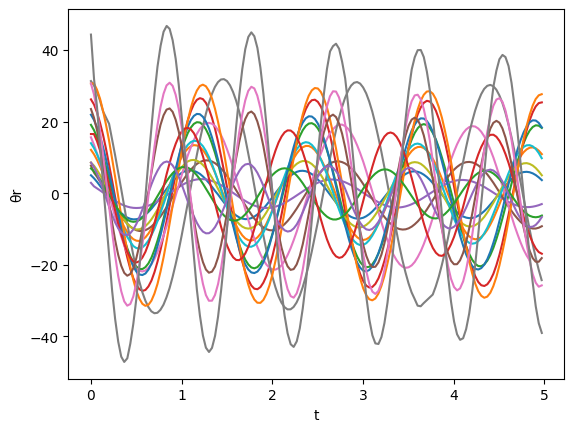

In [48]:
import os
import pandas as pd

# Adjust the input directory path to go up one level from the current directory
input_dir = os.path.join('..', 'datasets')

datasets = []

for folder in os.listdir(input_dir):
    folder_path = os.path.join(input_dir, folder)
    if os.path.isdir(folder_path):
        for file in os.listdir(folder_path):
            if file.endswith('.csv'):
                # Add dataset to the list with subfolder and folder
                datasets.append(os.path.join(folder, file))

dataset_params = []

for i, dataset in enumerate(datasets):
    print(f"{i}: {dataset}")
    # Load a specific dataset into a DataFrame
    DATASET_CHOSEN = i
    data = pd.read_csv(os.path.join(input_dir, datasets[DATASET_CHOSEN]))
    L, dL = get_largo(data)
    data = format_pd(data)
    plot_data(data)
    #plt.show()
    tita0, amplitud, T, frecuencia, sigma_tita0, sigma_amplitud, sigma_T, sigma_frecuencia = get_all_params(data)
    dicc = gen_dicc(data)
    dataset_params.append((L, tita0, amplitud, T, frecuencia, (23 if dataset.split()[0] == "plata" else 72), dL, sigma_tita0, sigma_amplitud, sigma_T, sigma_frecuencia))
    print(f"θ0: {tita0}, A: {amplitud}, T: {T}, f: {frecuencia}")
    #plot_approximation(data, tita0=tita0, amplitud=amplitud, frecuencia=frecuencia, periodo=T)
    #plt.show()


In [53]:
def graph_params(dataset_params):
    # Creo un DataFrame con los datos
    df = pd.DataFrame(dataset_params, columns=["L", "tita0", "A", "T", "f", "m", "dL", "sigma_tita0", "sigma_A", "sigma_T", "sigma_f"])

    # Fit a linear regression model to estimate gravity
    reg = LinearRegression().fit(df["L"].values.reshape(-1, 1), (df["T"]**2).values.reshape(-1, 1))

    # Plot T^2 vs L
    plt.figure()
    plt.errorbar(df["L"], df["T"]**2, label='Datos', xerr=df["dL"], yerr=df["sigma_T"] * 2 * df["T"], fmt='o')
    x = np.linspace(df["L"].min(), df["L"].max(), 100)
    plt.plot(x, reg.predict(x.reshape(-1, 1)), color="red", label='Fit Lineal')
    delta = 2 * df["sigma_T"].mean() * df["T"].mean()
    plt.fill_between(x,
                     reg.predict(x.reshape(-1, 1)).reshape(-1) - delta,
                     reg.predict(x.reshape(-1, 1)).reshape(-1) + delta,
                     color='red', alpha=0.2, label="Intervalos de error")
    g = 9.80665 * 100
    plt.plot(x, (4 * np.pi**2 / g) * x, color="green", label='Recta Teórica')
    plt.xlabel(r'$Largo\ [cm]$')
    plt.ylabel(r'$T^2\ [s^2]$')
    #plt.title('T^2 vs L')
    plt.legend()
    plt.show()

    # Estimate gravity (g) from the slope (T^2 = (4 * pi^2 / g) * L)
    slope = reg.coef_[0][0]
    intercept = reg.intercept_[0]
    g_estimated = (4 * np.pi**2 / slope) / 100  # cm to m

    # Calculate uncertainty in the slope
    residuals = (df["T"]**2) - (slope * df["L"] + intercept)
    residual_sum_of_squares = np.sum(residuals**2)
    degrees_of_freedom = len(df["L"]) - 2
    standard_error = np.sqrt(residual_sum_of_squares / degrees_of_freedom)
    slope_uncertainty = standard_error / np.sqrt(np.sum((df["L"] - df["L"].mean())**2))

    # Propagate uncertainty to g
    g_uncertainty = g_estimated * (slope_uncertainty / slope)

    print(f"Estimated gravity (g): {g_estimated} ± {g_uncertainty} m/s^2")

    # T vs m with color gradient based on L value
    df["L"] = df["L"].round(1)
    filtered_df = df
    unique_lengths = np.sort(filtered_df["L"].unique())  # Sort the unique lengths
    norm = plt.Normalize(filtered_df["L"].min(), filtered_df["L"].max())
    colors = plt.cm.viridis(norm(unique_lengths))

    plt.figure()
    ax = plt.gca()  # Get current axes
    for length, color in zip(unique_lengths, colors):
        subset = filtered_df[filtered_df["L"] == length]
        ax.errorbar(subset["m"], subset["T"], yerr=subset["sigma_T"], fmt='o', color=color, xerr=1)  # Add error bars

    plt.xlabel(r'$Masa\ [g]$')
    plt.ylabel(r'$T\ [s]$')
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
    sm.set_array([])
    plt.colorbar(sm, ax=ax, label=r'$Largo\ [cm]$')
    plt.legend()
    plt.show()

    # T vs tita0 with color gradient based on L value
    plt.figure()
    ax = plt.gca()  # Get current axes
    for length, color in zip(unique_lengths, colors):
        subset = filtered_df[filtered_df["L"] == length]
        ax.errorbar(subset["tita0"], subset["T"], yerr=subset["sigma_T"], fmt='o', color=color, xerr=0.2)  # Add error bars

    plt.xlabel(r'$\theta_0\ [deg]$')
    plt.ylabel(r'$T\ [s]$')
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
    sm.set_array([])
    plt.colorbar(sm, ax=ax, label=r'$Largo\ [cm]$')
    plt.legend()
    plt.show()

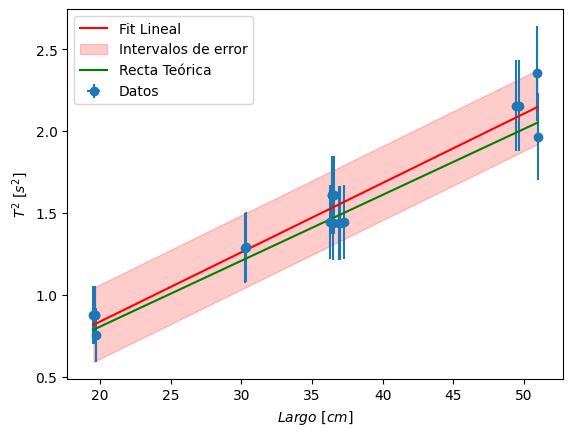

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Estimated gravity (g): 9.321777711572654 ± 0.5194169816907779 m/s^2


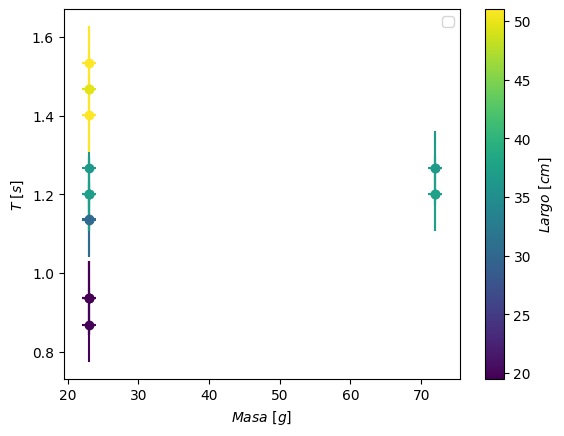

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


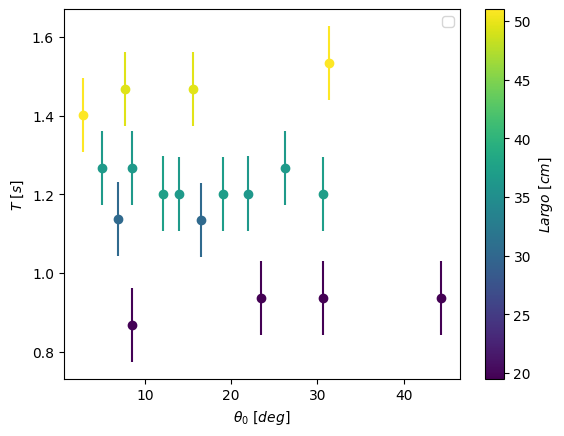

In [54]:
graph_params(dataset_params)